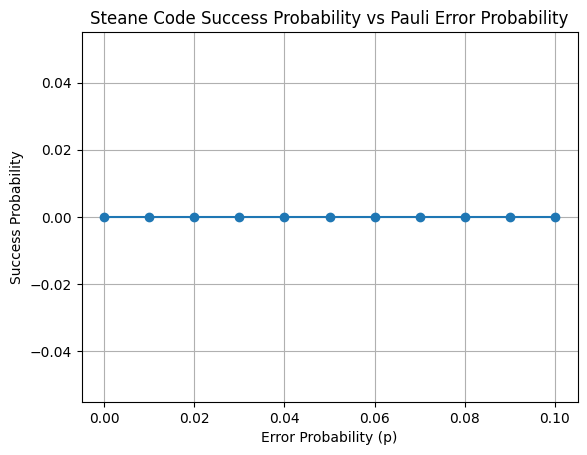

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import pauli_error, NoiseModel

def steane_logical_zero():
    qc = QuantumCircuit(7, name="|0_L>")
    qc.h([0, 1, 2])
    qc.cx(0, 3); qc.cx(0, 4)
    qc.cx(1, 3); qc.cx(1, 5)
    qc.cx(2, 4); qc.cx(2, 5)
    qc.cx(0, 6); qc.cx(1, 6); qc.cx(2, 6)
    return qc

def pauli_noise_model(p):
    error = pauli_error([('X', p), ('Y', p), ('Z', p), ('I', 1 - 3 * p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['id'])
    return noise_model

def build_full_steane_circuit(p, x=0):
    qr = QuantumRegister(7, name="data")
    qc = QuantumCircuit(qr)

    # Encode logical zero (or one if x == 1)
    qc = qc.compose(steane_logical_zero(), qubits=range(7))
    if x == 1:
        qc.x(qr)

    qc.barrier()
    qc.id(qr)  # Apply identity so noise model has a target
    qc.barrier()

    # Define Steane stabilizer matrix
    H = np.array([
        [1, 0, 0, 1, 0, 1, 1],
        [0, 1, 0, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 1, 1]
    ])

    # Ancilla and classical registers for syndrome
    ancX = QuantumRegister(3, name="ancX")
    ancZ = QuantumRegister(3, name="ancZ")
    sX = ClassicalRegister(3, name="sX")
    sZ = ClassicalRegister(3, name="sZ")
    qc.add_register(ancX, ancZ, sX, sZ)

    # Measure Z stabilizers with X ancillas
    for i, row in enumerate(H):
        qc.h(ancZ[i])
        for j in np.where(row)[0]:
            qc.cx(qr[j], ancZ[i])
        qc.h(ancZ[i])
        qc.barrier()

    # Measure X stabilizers with Z ancillas
    for i, row in enumerate(H):
        qc.h(ancX[i])
        for j in np.where(row)[0]:
            qc.cx(ancX[i], qr[j])
        qc.h(ancX[i])
        qc.barrier()

    qc.measure(ancX, sX)
    qc.measure(ancZ, sZ)

    # Final measurement
    cr_data = ClassicalRegister(7, name="meas")
    qc.add_register(cr_data)
    qc.measure(qr, cr_data)

    return qc

def run_steane(p, x=0, shots=1024):
    qc = build_full_steane_circuit(p, x)
    backend = AerSimulator()
    qc_t = transpile(qc, backend)
    result = backend.run(qc_t, noise_model=pauli_noise_model(p), shots=shots).result()
    counts = result.get_counts()

    # Only look at the measurement of the data qubits (first 7 bits)
    success_count = 0
    for outcome, count in counts.items():
        data_bits = outcome[-7:]  # last 7 bits are from data qubits
        if data_bits == '0000000':
            success_count += count
    return success_count / shots

# Run simulations for various p values
ps = np.linspace(0, 0.1, 11)
success_probs = [run_steane(p) for p in ps]

# Plot
plt.plot(ps, success_probs, marker='o')
plt.title("Steane Code Success Probability vs Pauli Error Probability")
plt.xlabel("Error Probability (p)")
plt.ylabel("Success Probability")
plt.grid(True)
plt.show()
